<a href="https://colab.research.google.com/github/emgrande/Rn_hydrologic_tracer/blob/main/Codes/SGD_calculation_Rn_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### These codes can be used to calculate SGD from measured $^{222}Rn$ timeseries

Here we recreate an example used in Grande and Moran, A review and evaluation of Rn as a hydrologic tracer.
The codes are based on Burnett and Dulaiova, 2006 (10.1016/j.csr.2005.12.003)

In [33]:
#load the necessary libraries
library(tidyverse)
library(lubridate)

In [ ]:
#installing libraries can take a few minutes
install.packages("imputeTS")
library(imputeTS)

Load the data and convert the date time column to the correct format

In [34]:
data = read_csv("https://raw.githubusercontent.com/emgrande/Rn_hydrologic_tracer/main/Data/Kiholo_timeseries.csv")%>%
  mutate(across(.cols = 1, .fns = ~ parse_date_time(., c("ymdHMS", "ymdHM", "mdyHM", "mdyHMS")))) %>% #Convert the datetime column to a date time format
  mutate(across(.cols = -1, .fns = as.numeric)) #convert all columns, except for the first one, to numeric (important if there are NAs in the data)


Rows: 13 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): datetime
dbl (9): depth_m, temp_C, sal, Rn_Bqm3, Rn_air_Bqm3, Rn_gw_Bqm3, Rn_offshore...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


print the first six rows of the data to check the tibble's structure

In [ ]:
head(data)

datetime,depth_m,temp_C,sal,Rn_Bqm3,Rn_air_Bqm3,Rn_gw_Bqm3,Rn_offshore_Bqm3,wind_ms,Ra226_wat_Bqm3
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015-02-19 11:00:00,-0.308,22.393,13.98315,6.67,0.2,500,0.2,1.88,0.2
2015-02-19 12:00:00,-0.282,23.233,16.75990,6.67,0.2,500,0.2,1.89,0.2
2015-02-19 13:00:00,-0.173,24.245,19.25962,6.67,0.2,500,0.2,1.89,0.2
2015-02-19 14:00:00,-0.009,24.890,25.89547,6.67,0.2,500,0.2,1.90,0.2
2015-02-19 15:00:00,0.135,25.353,23.46996,232.03,0.2,500,0.2,1.90,0.2
2015-02-19 16:00:00,0.237,25.398,21.07727,217.28,0.2,500,0.2,1.91,0.2


Start the Calculations

In [35]:
#we will save the results in a new data frame
df <- data %>%
  mutate(
    #We fill in any mixing value by linearly interpolating consecutive measurements. The user may consider a spline or exponential interpolaion if there are large 
    #gaps in their time series.
    Rn_Bqm3 = if_else(is.na(Rn_Bqm3), na_interpolation(Rn_Bqm3), Rn_Bqm3),
    temp_C = if_else(is.na(temp_C), na_interpolation(temp_C), temp_C),
    sal = if_else(is.na(sal), na_interpolation(sal), sal),
    
    # Calculate the timestep in minutes
    time_step = (datetime %>% as.numeric() - lag(datetime %>% as.numeric())) / 60,
    
    #Calculate the change in water depth between two time stamps
    delta_depth = depth_m - lag(depth_m),
    
    #Convert water temperature from Celsius to Kelvin (skip this step if you measure temperature in Kelvins)
    temp_K = temp_C + 273.15,
    
    #Calculate the rate loss of Rn to the atmosphere based on water temperature and salinity
    kw_air = exp(-76.14 + 120.36 * (100 / temp_K) + 31.26 * log(temp_K / 100) + sal *
            (-0.2631 + 0.1673 * (temp_K / 100) + (-0.0270 * (temp_K / 100)^2))) * temp_K / 273.15,
    
    # Calculate Rn losses by evasion into the atmosphere (citations for all equations are found in the manuscript)
    f_Rn_atm_Bqm2hr = case_when(wind_ms > 3.6 ~ (0.45 * wind_ms^1.6 *((0.0086 / 10^(-(980 / temp_K + 1.59))) / 600)^(-1 / 2)) / 100 / 60 * (Rn_Bqm3 - kw_air * Rn_air_Bqm3) * 60, 
                                wind_ms > 1.5 ~(0.45 * wind_ms^1.6 * ((0.0086 / 10^(-(980 / temp_K + 1.59))) / 600)^(-2 / 3)) / 100 / 60 * (Rn_Bqm3 - kw_air * Rn_air_Bqm3) * 60,
                                TRUE ~ (0.45 * 1.5^1.6 *((0.0086 / 10^(-(980 / temp_K + 1.59))) / 600)^(-2 / 3)) / 100 / 60 *(Rn_Bqm3 - kw_air * Rn_air_Bqm3) * 60),
    
    # subtract dissolved 226Ra in water from Rn in water to calculate excess Rn
    ex_Rn_wat_Bqm3 = Rn_Bqm3 - Ra226_wat_Bqm3,
    
    # Calculate the excess Rn inventory
    ex_Rn_wat_inv_Bqm2 = ex_Rn_wat_Bqm3 * depth_m,
    
    # Calculate the change in Rn inventory in per hour flux
    f_Rn_gross_Bqm2hr = (ex_Rn_wat_inv_Bqm2 - lag(ex_Rn_wat_inv_Bqm2)) * 60 / time_step,
    
    # Calculate the Rn brought in by tides from offshore (only during flood tides)
    f_Rn_flood_Bqm2hr = if_else(depth_m - lag(depth_m) > 0,
                                 ((depth_m - lag(depth_m)) * Rn_offshore_Bqm3) * 60 / time_step, 0, NA_real_),
    
    # Rn lost from coastal to offshore areas (only during ebb tides)
    f_Rn_ebb_Bqm2hr = if_else(depth_m - lag(depth_m) < 0,
                               (-(depth_m - lag(depth_m)) * Rn_Bqm3) * 60 / time_step, 0,NA_real_),
    
    # Calculate the net Rn flux in per hour
    f_Rn_net_Bqm2hr = f_Rn_gross_Bqm2hr +
      f_Rn_atm_Bqm2hr +
      f_Rn_ebb_Bqm2hr -
      f_Rn_flood_Bqm2hr,
    
    # We used a conservative approach to calculate Rn losses due to mixing by making f_Rn_mix_Bqm2hr = to negative f_Rn_net_Bqm2hr  
    f_Rn_mix_Bqm2hr = if_else(f_Rn_net_Bqm2hr < 0,
                               -f_Rn_net_Bqm2hr, 0, NA_real_),
    
    # Calculate the total Rn flux
    f_Rn_total_Bqm2hr = f_Rn_net_Bqm2hr + f_Rn_mix_Bqm2hr,
    
    #Now we can calculate groundwater discharge in m3m2d as:
    q_gw_m3m2d = (f_Rn_total_Bqm2hr / Rn_Bqm3) * 24
    
  ) 

Plot the results

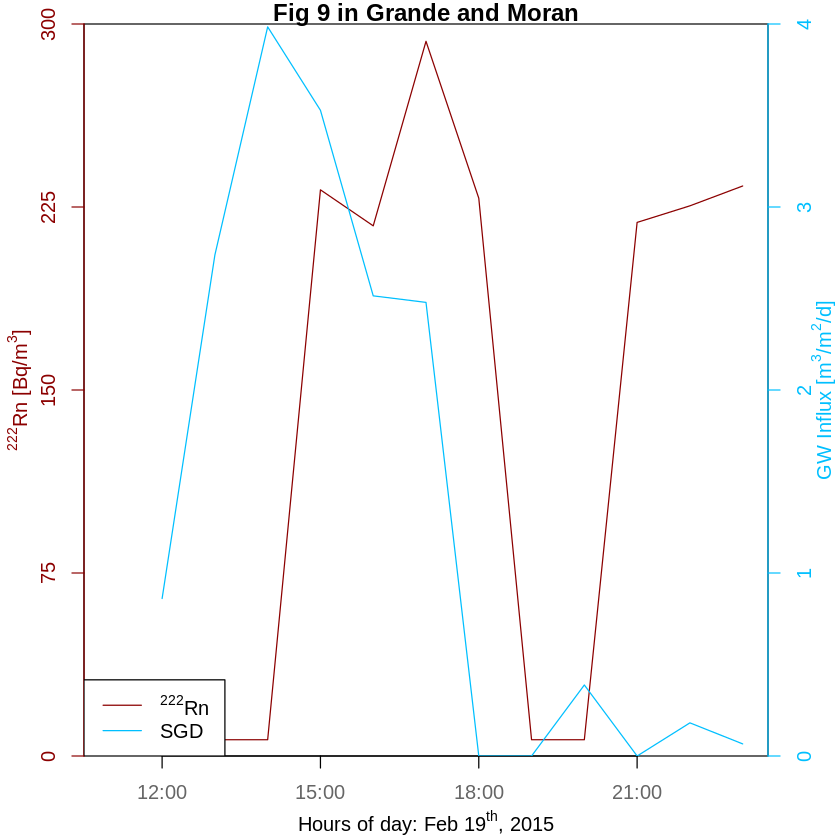

In [36]:
par(mar = c(3.5,3.5,1,3), oma = c(0,0,0,0))

plot(df$datetime,df$Rn_Bqm3, type = "l", col = "darkred", ylab = "", xlab= "",
     yaxt = "n", yaxs = "i", col.axis = "grey40", ylim = c(0,300))
axis(2, at = seq(0,300, length.out = 5), col = "darkred",col.axis = "darkred")
mtext(expression(""^222*"Rn [Bq/m"^3*"]"),2,line = 2, col = "darkred")

par(new = T)
plot(df$datetime,df$q_gw_m3m2d, type = "l", col = "deepskyblue", xaxt = "n",
     yaxt = "n", xlab = "", ylab = "", yaxs = "i",axes=FALSE, frame.plot=F, ylim = c(0,4), main = "Fig 9 in Grande and Moran")
axis(4, at = seq(0,ceiling(max(df$q_gw_m3m2d, na.rm = T)), length.out = 5), col = "deepskyblue", col.axis = "deepskyblue")
mtext(expression("GW Influx [m"^3*"/m"^2*"/d]"),4,line = 2, col = "deepskyblue")
legend("bottomleft", legend = c(expression(""^222*"Rn"),"SGD"),
       col = c("darkred", "deepskyblue"), lty = 1)
mtext(expression("Hours of day: Feb 19"^th*", 2015"),1,line = 2.5)